In [10]:
import numpy as np
import matplotlib
# %matplotlib widget
import matplotlib.pyplot as plt
plt.style.use('../l3.mplstyle')
import pandas as pd
from scipy.optimize import curve_fit
from scipy.signal import find_peaks

## First measurement colimated beam of only dioide

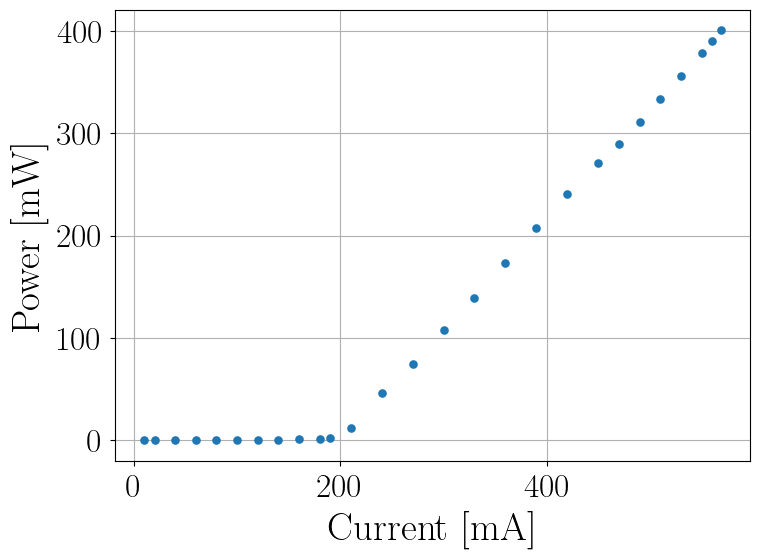

In [11]:
I = np.array([569,560,550,530,510,490,470,450,420,390,360,330,300,270,240,210,190,180,160,140,120,100,80,60,40,20,10])*1e-3 # A
P2 = np.array([400.5,390.6,378.9,356,334,311,289.9,271,240.5,207.8,173.4,138.8,108,75,46,12,2.1,1.6,1,0.7,0.5,0.35,0.24,0.15,0.08,0.02,0.002])*1e-3 # W# +/-1mW
fig,ax = plt.subplots()
ax.plot(I*1e3,P2*1e3,"o")
ax.set(xlabel='Current [mA]', ylabel='Power [mW]')
ax.grid()

## I over P for assembled laser

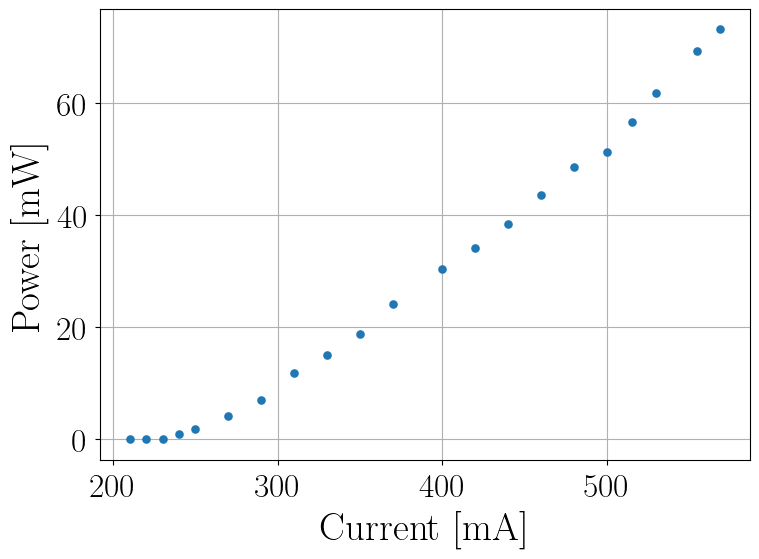

In [12]:
I = np.array([569,555,530,515,500,480,460,440,420,400,370,350,330,310,290,270,250,240,230,220,210])*1e-3 # A
P = np.array([73.2,69.4,61.8,56.7,51.4,48.6,43.7,38.4,34.1,30.5,24.2,18.8,15.0,11.8,7.0,4.1,1.9,1.0,0,0,0])*1e-3 # W
fig,ax = plt.subplots()
ax.plot(I*1e3,P*1e3,"o")
ax.set(xlabel='Current [mA]', ylabel='Power [mW]')
ax.grid()

## 6.4 Laser Spiking

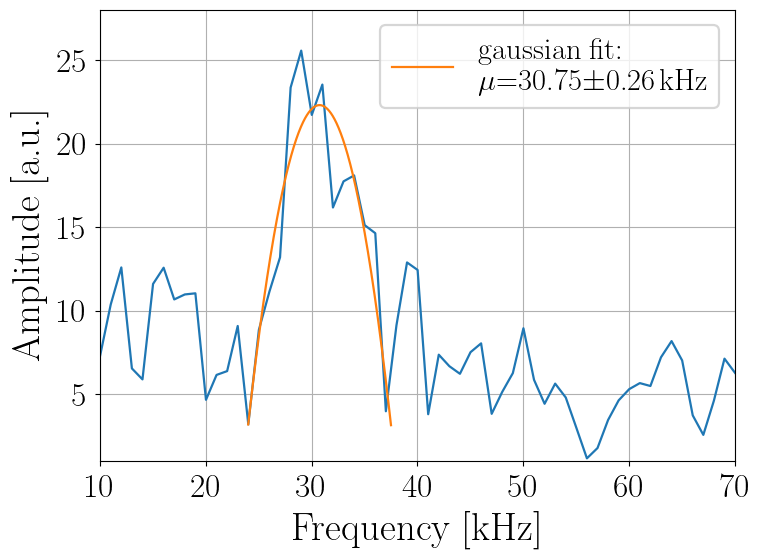

In [13]:
data = pd.read_csv('F0001CH1.CSV')
t, V = np.array(data.iloc[:,3]), np.array(data.iloc[:,4])
fft = np.abs(np.fft.rfft(V))
freq = np.fft.rfftfreq(len(V),t[1]-t[0])
def gaussian(x,a,b,c,d):
    return a*np.exp(-(x-b)**2/(2*c**2))+d
mask = (freq>24000)&(freq<38000)
popt, pcov = curve_fit(gaussian, freq[mask], fft[mask], p0=[20,30700,300,5])
fig,ax = plt.subplots()
ax.plot(freq*1e-3,fft) # Cut away pedestal and beating peak
fit_freqs = np.linspace(24,37.5,1000)*1e3
ax.plot(fit_freqs*1e-3,gaussian(fit_freqs,*popt), label= 'gaussian fit:\n$\mu$={:.2f}$\pm${:.2f}$\,$kHz'.format(popt[1]*1e-3,np.sqrt(pcov[1,1])*1e-3))
ax.legend()
ax.set(xlim=[10,70], ylim=[1,28], xlabel='Frequency [kHz]', ylabel='Amplitude [a.u.]')
ax.grid()
fig.tight_layout()
fig.savefig('plots/spiking_freq.pdf', bbox_inches='tight')

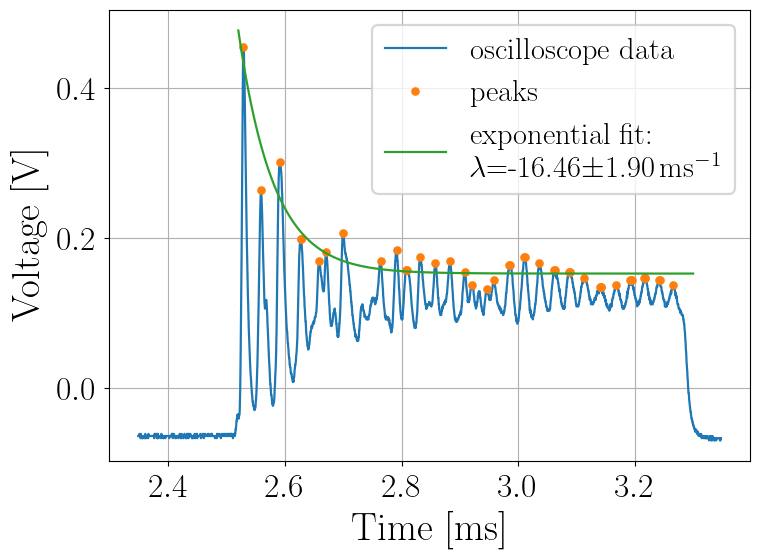

In [14]:

peak_mask = V>0.125
t_pos, V_pos = t[peak_mask], V[peak_mask]
peaks, _ = find_peaks(V_pos, prominence=0.005)
def exponential(x,a,b,c,d):
    return a*np.exp(b*(x-c))+d
popt, pcov = curve_fit(exponential, t_pos[peaks], V_pos[peaks], p0=[1,-1e3,0.0025,0.11])
fig, ax = plt.subplots()
ax.plot(t*1e3,V, label='oscilloscope data')
ax.plot(t_pos[peaks]*1e3,V_pos[peaks],"o", label='peaks')
t_fit = np.linspace(2.52,3.3,1000)*1e-3
ax.plot(t_fit*1e3,exponential(t_fit,*popt), label='exponential fit:\n$\\lambda$={:.2f}$\pm${:.2f}$\,$ms$^-$$^1$'.format(popt[1]*1e-3,np.sqrt(pcov[1,1])*1e-3))
ax.set(xlabel='Time [ms]', ylabel='Voltage [V]')
ax.grid()
ax.legend()
fig.tight_layout()
fig.savefig('plots/spiking_expo.pdf', bbox_inches='tight')

## 7.1 Q Switching - Frequency over current

--> should this even be linear?

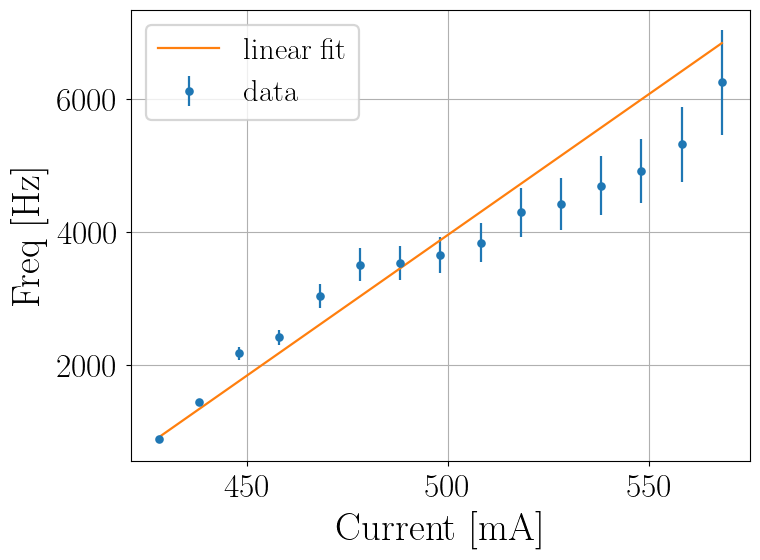

In [15]:
t =  np.array([[1120,1140,1110],[680,652,732],[468,456,452],[420,392,428],[320,350,316],[280,302,272],[296,276,276],[260,280,280],[266,266,248],[228,228,242],[222,222,234],[222,204,212],[200,210,200],[184,184,196],[160,160,160]])*1e-6 # s
t_mean = np.mean(t,axis=1)
I = np.array([428,438,448,458,468,478,488,498,508,518,528,538,548,558,568])*1e-3 # A
err_f = 1/t_mean**2 * 20e-6 #Hz 
def linear(x,a,b):
    return a*x+b
popt, pcov = curve_fit(linear, I, 1/t_mean, sigma=err_f)
fig,ax = plt.subplots()
ax.errorbar(I*1e3, 1/(t_mean), err_f, None, fmt="o", label='data')
ax.plot(I*1e3,linear(I,*popt), label='linear fit')
ax.set(xlabel='Current [mA]', ylabel='Freq [Hz]')
ax.grid()
ax.legend()
fig.tight_layout()
fig.savefig('plots/qswitch.pdf', bbox_inches='tight')

## 8 Frequency doubling
532nm wavelength

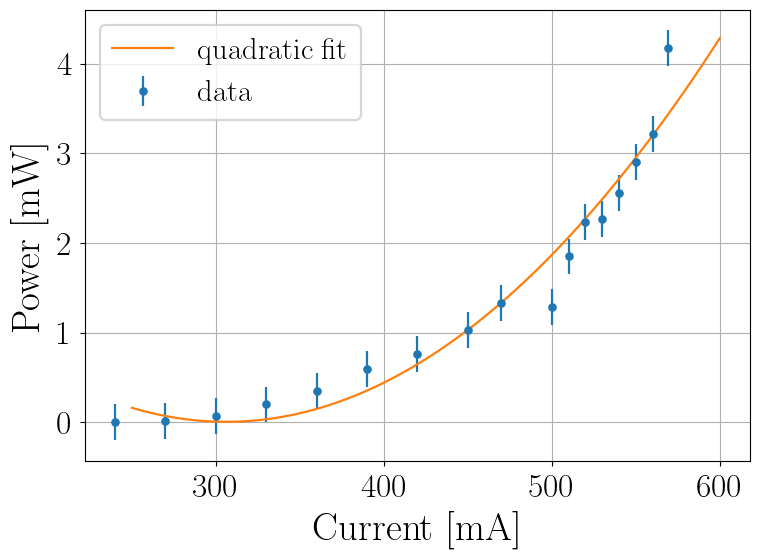

In [16]:
def quadratic(x,a,b,c):
    return a*(x-b)**2+c
I = np.array([569,560,550,540,530,520,510,500,470,450,420,390,360,330,300,270,240])*1e-3 # A
P1 = np.array([4.17,3.22,2.90,2.56,2.27,2.23,1.85,1.29,1.33,1.03,0.76,0.60,0.35,0.20,0.07,0.02,0])*1e-3 # W # fehler hat so um 0.2 gewackelt
P1_err = 0.2e-3
popt, pcov = curve_fit(quadratic, I, P1, sigma=P1_err*np.ones_like(P1), absolute_sigma=True)
fig,ax = plt.subplots()
ax.errorbar(I*1e3,P1*1e3,P1_err*1e3,None,"o", label='data')
ax.plot(np.linspace(250, 600, 1000),quadratic(np.linspace(250, 600, 1000)*1e-3,*popt)*1e3, label='quadratic fit')
ax.set(xlabel='Current [mA]', ylabel='Power [mW]')
ax.grid()
ax.legend()
fig.tight_layout()
fig.savefig('plots/freqdoub_p2.pdf', bbox_inches='tight')

1064nm

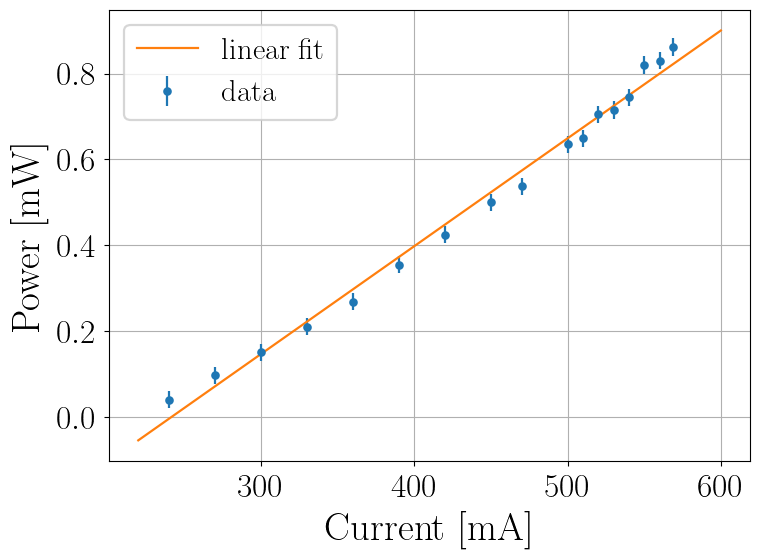

In [17]:
I = np.array([569,560,550,540,530,520,510,500,470,450,420,390,360,330,300,270,240])*1e-3 # A
P2 = np.array([862,830,820,745,715,705,649,635,537,500,425,355,269,210,151,97,40])*1e-6 # W
P2_err = 20e-6
popt, pcov = curve_fit(linear, I, P2, absolute_sigma=True)
fig,ax = plt.subplots()
ax.errorbar(I*1e3,P2*1e3,P2_err*1e3, None, "o", label='data')
ax.plot(np.linspace(220,600,1000), linear(np.linspace(220,600,1000)*1e-3,*popt)*1e3, label='linear fit')
ax.set(xlabel='Current [mA]', ylabel='Power [mW]')
ax.grid()
ax.legend()
fig.tight_layout()
fig.savefig('plots/freqdoub_p1.pdf', bbox_inches='tight')

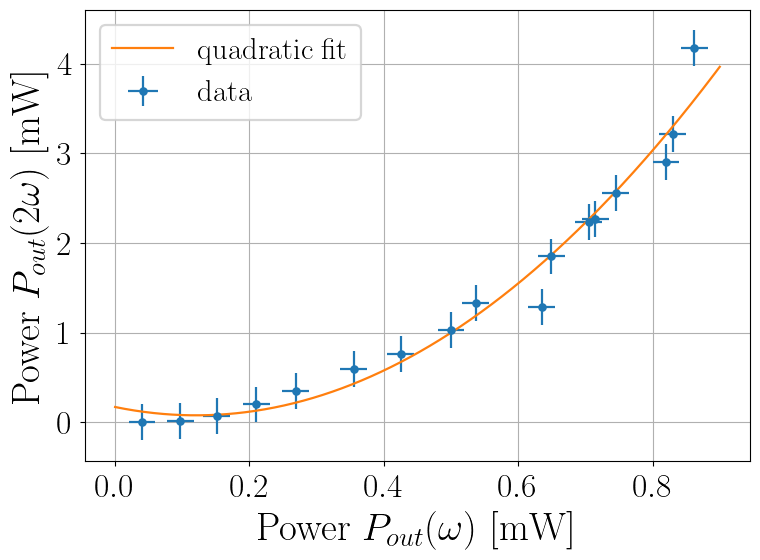

In [23]:
popt, pcov = curve_fit(quadratic, P2, P1, sigma=P1_err*np.ones_like(P1), absolute_sigma=True, p0=[5000,0,0])
fig,ax = plt.subplots()
ax.errorbar(P2*1e3,P1*1e3,P1_err*1e3, P2_err*1e3,"o", label='data')
ax.plot(np.linspace(0,0.9,1000),quadratic(np.linspace(0,0.9e-3,1000),*popt)*1e3, label='quadratic fit')
ax.set(xlabel='Power $P_{out}(\omega)$ [mW]', ylabel='Power $P_{out}(2\omega)$ [mW]')
ax.grid()
ax.legend()
fig.tight_layout()
fig.savefig('plots/freqdoub_p2_vs_p1.pdf', bbox_inches='tight')